In [2]:
%matplotlib inline

Analyze Merfish data
========================

This tutorial shows how to apply Squidpy for the analysis of Merfish data.

The data used here was obtained from {cite}`Moffitt2018-me`.
We provide a pre-processed subset of the data, in {class}`anndata.AnnData` format.
For details on how it was pre-processed, please refer to the original paper.


Import packages & data
----------------------
To run the notebook locally, create a conda environment as *conda env create -f environment.yml* using this
`environment.yml <https://github.com/scverse/squidpy_notebooks/blob/main/environment.yml>`_.

In [3]:
import scanpy as sc
import squidpy as sq

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

# load the pre-processed dataset
adata = sq.datasets.merfish()
adata

scanpy==1.9.2 anndata==0.8.0 umap==0.5.3 numpy==1.21.0 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.2 python-igraph==0.10.2 pynndescent==0.5.7
squidpy==1.2.2


100%|██████████| 49.2M/49.2M [00:07<00:00, 7.05MB/s]


AnnData object with n_obs × n_vars = 73655 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch'
    uns: 'Cell_class_colors'
    obsm: 'spatial', 'spatial3d'

This datasets consists of consecutive slices from the mouse hypothalamic preoptic region.
It represents an interesting example of how to work with 3D spatial data in Squidpy.
Let's start with visualization: we can either visualize the 3D stack of slides
using {func}`scanpy.pl.embedding`:

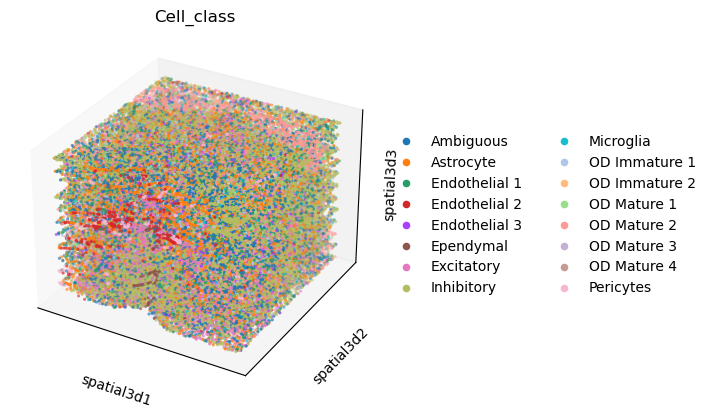

In [4]:
sc.pl.embedding(adata, basis="spatial3d", projection="3d", color="Cell_class")

Or visualize a single slide with {func}`squidpy.pl.spatial_scatter`. Here the slide identifier
is stored in `adata.obs["Bregma"]`, see original paper for definition.

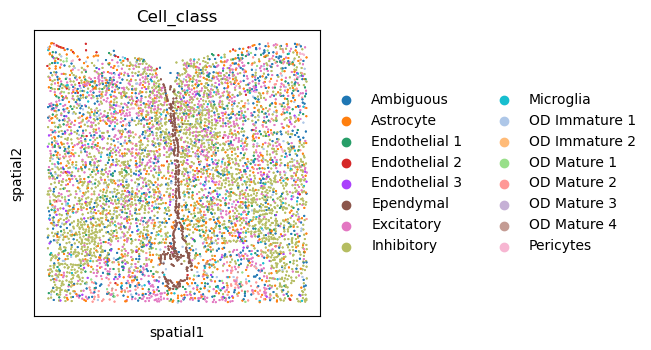

In [5]:
sq.pl.spatial_scatter(
    adata[adata.obs.Bregma == -9], shape=None, color="Cell_class", size=1
)

Neighborhood enrichment analysis in 3D
--------------------------------------
It is important to consider whether the analysis should be performed on the 3D
spatial coordinates or the 2D coordinates for a single slice. Functions that
make use of the spatial graph can already support 3D coordinates, but it is important
to consider that the z-stack coordinate is in the same unit metrics as the x, y coordinates.
Let's start with the neighborhood enrichment score. You can read more on the function
in the docs at {doc}`../examples/graph/compute_spatial_neighbors`.
First, we need to compute a neighbor graph with {func}`squidpy.gr.spatial_neighbors`.
If we want to compute the neighbor graph on the 3D coordinate space,
we need to specify ``spatial_key = "spatial3d"``.
Then we can use {func}`squidpy.gr.nhood_enrichment` to compute the score, and visualize
it with {func}`squidpy.pl.nhood_enrichment`.

100%|██████████| 1000/1000 [00:11<00:00, 88.86/s]


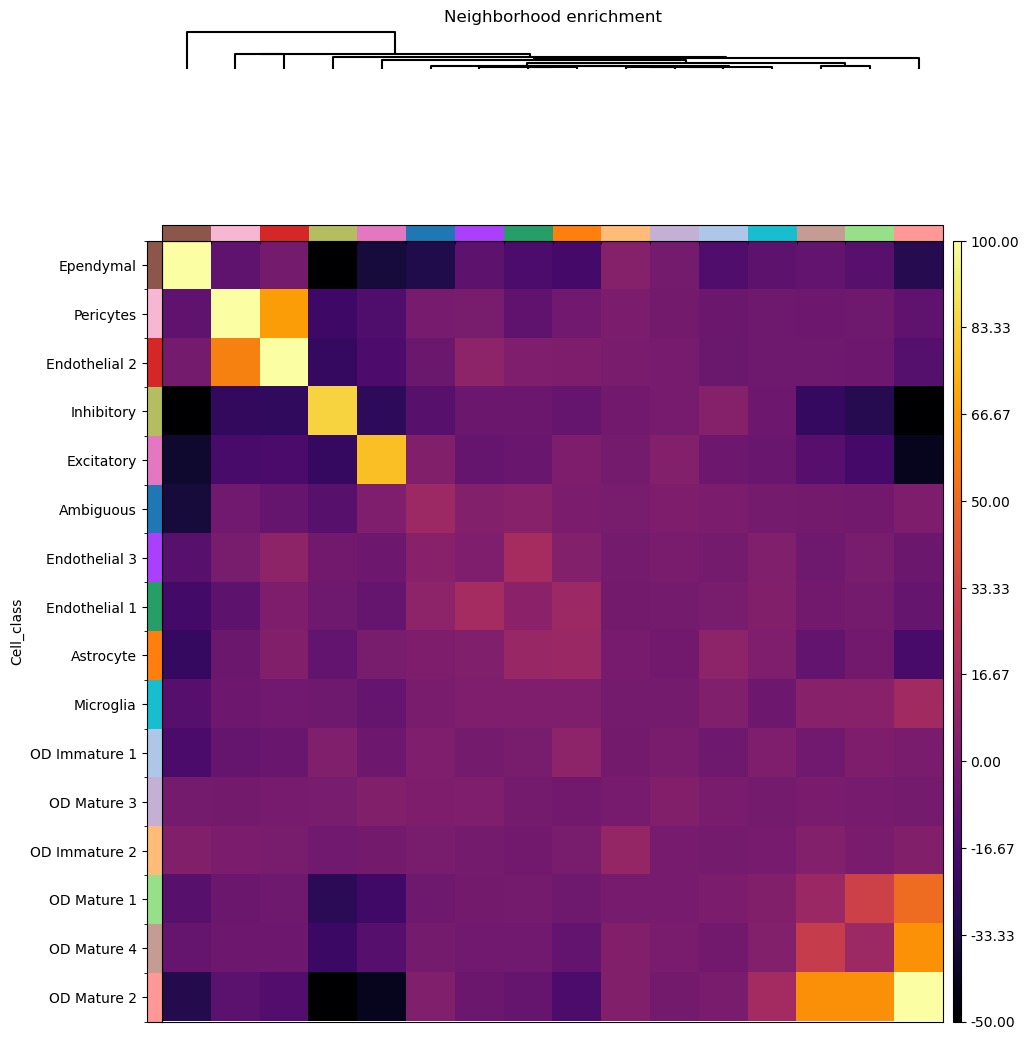

In [6]:
sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial3d")
sq.gr.nhood_enrichment(adata, cluster_key="Cell_class")
sq.pl.nhood_enrichment(
    adata, cluster_key="Cell_class", method="single", cmap="inferno", vmin=-50, vmax=100
)

We can visualize some of the co-enriched clusters with {func}`scanpy.pl.embedding`.
We will set `na_colors=(1,1,1,0)` to make transparent the other observations,
in order to better visualize the clusters of interests across z-stacks.

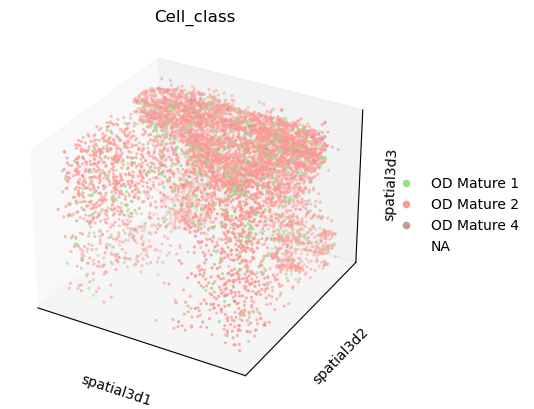

In [7]:
sc.pl.embedding(
    adata,
    basis="spatial3d",
    groups=["OD Mature 1", "OD Mature 2", "OD Mature 4"],
    na_color=(1, 1, 1, 0),
    projection="3d",
    color="Cell_class",
)

We can also visualize gene expression in 3D coordinates. Let's perform differential
expression testing with {func}`scanpy.tl.rank_genes_groups` and visualize the results

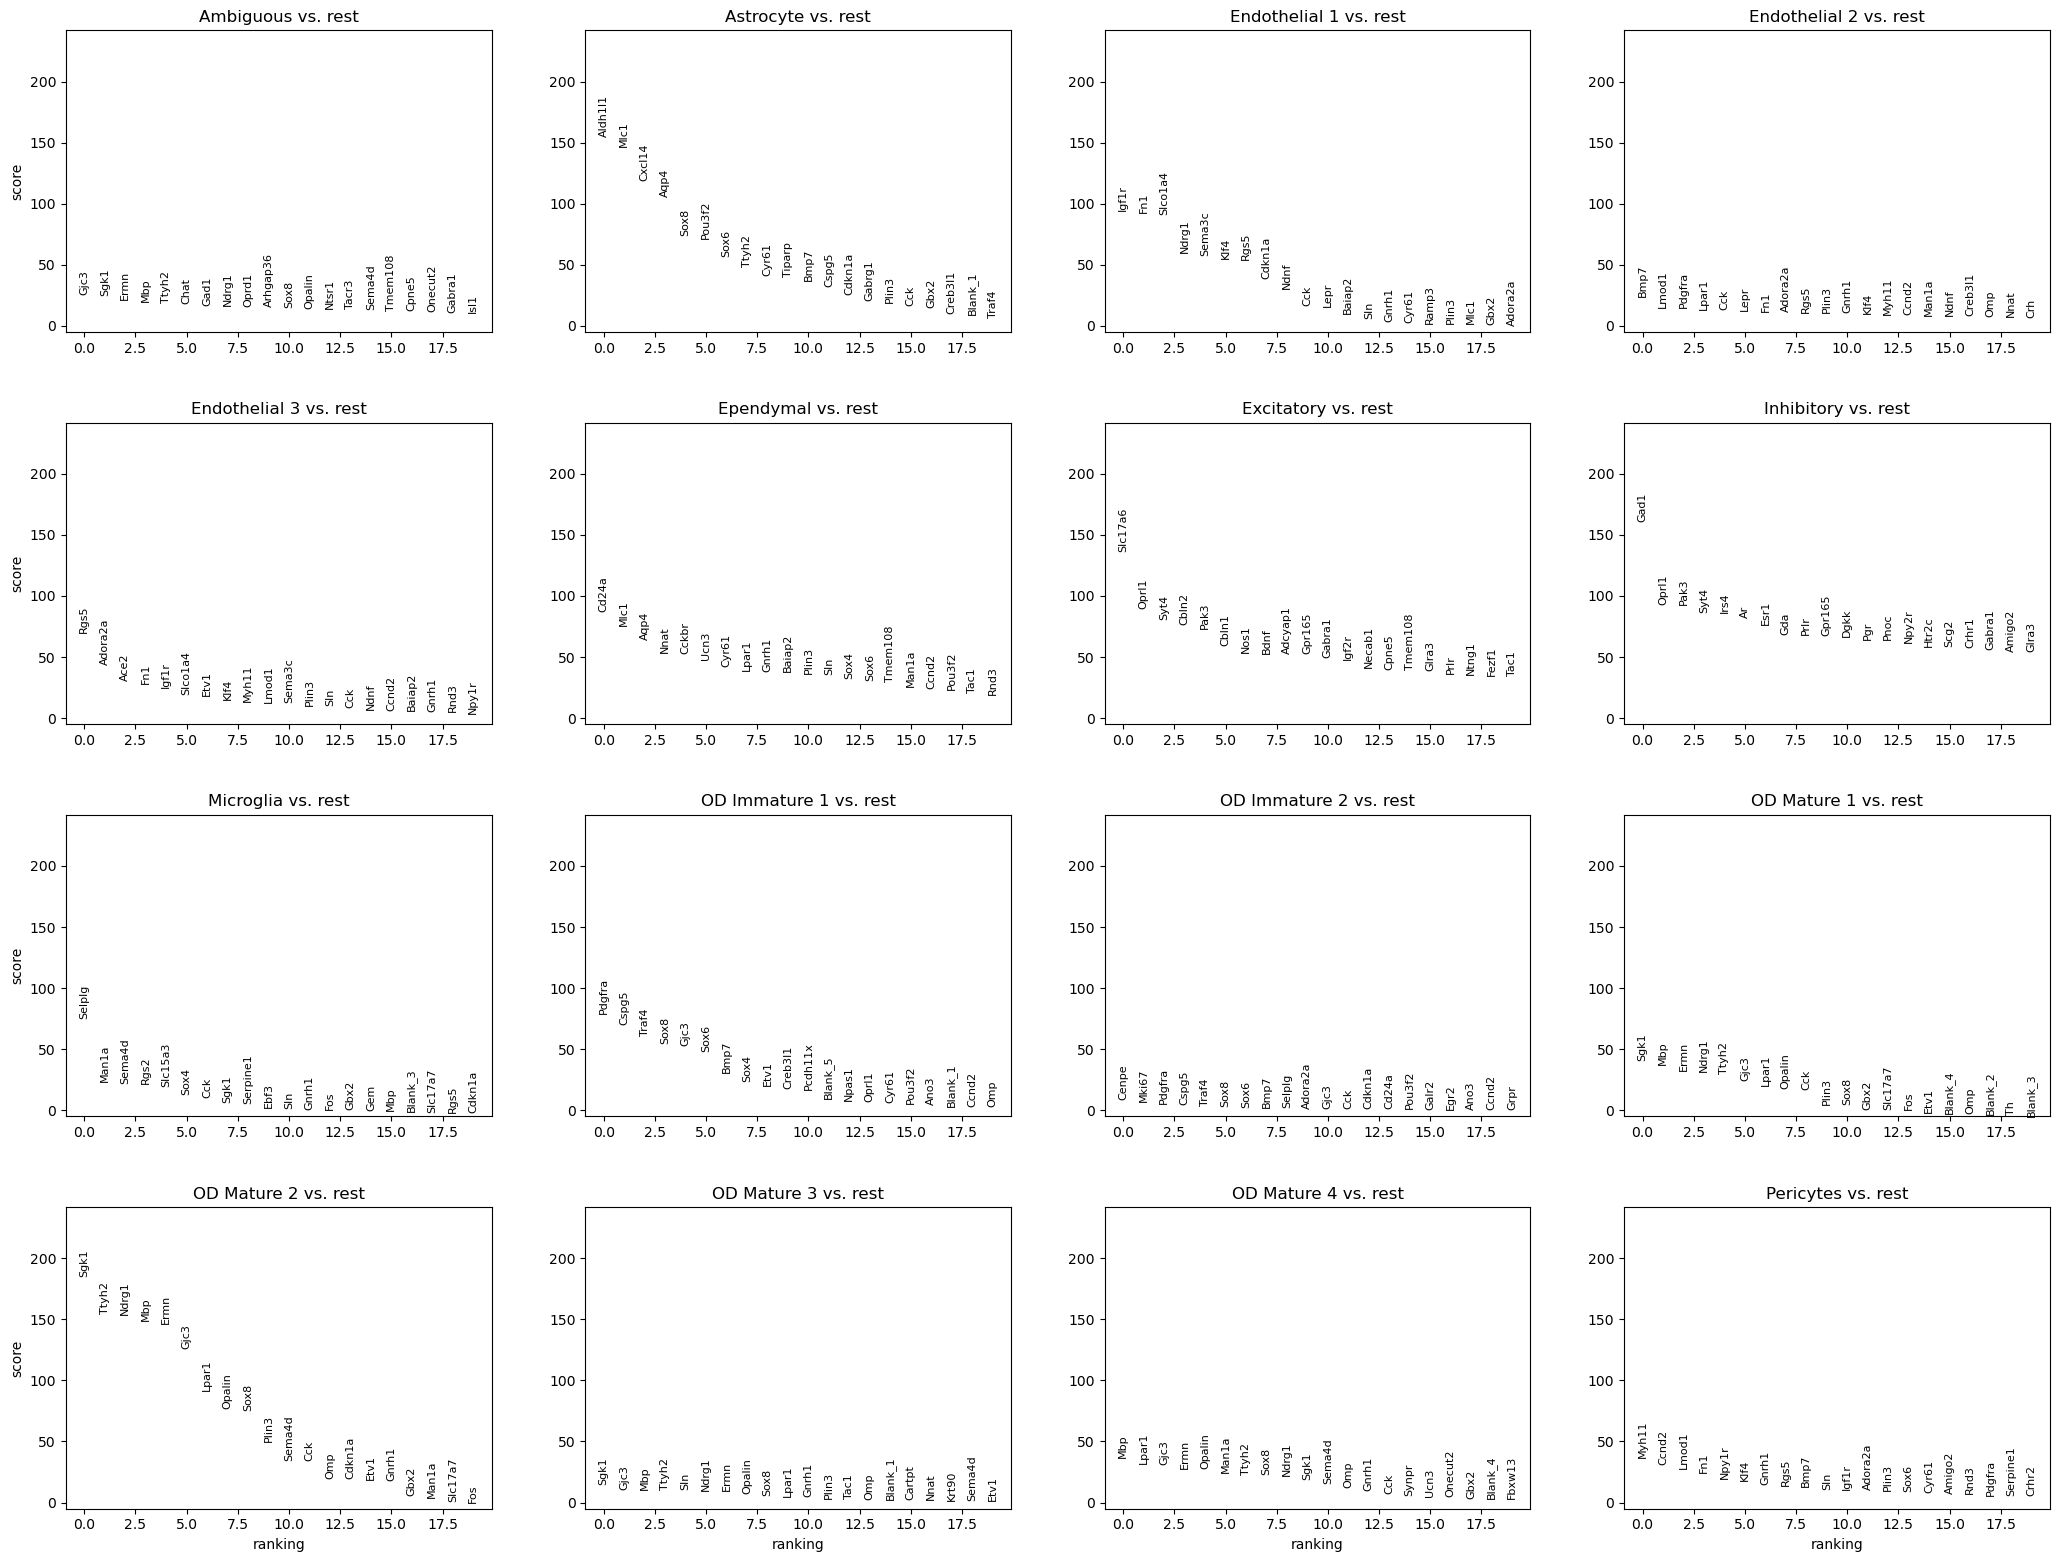

In [8]:
sc.tl.rank_genes_groups(adata, groupby="Cell_class")
sc.pl.rank_genes_groups(adata, groupby="Cell_class")

and the expression in 3D.

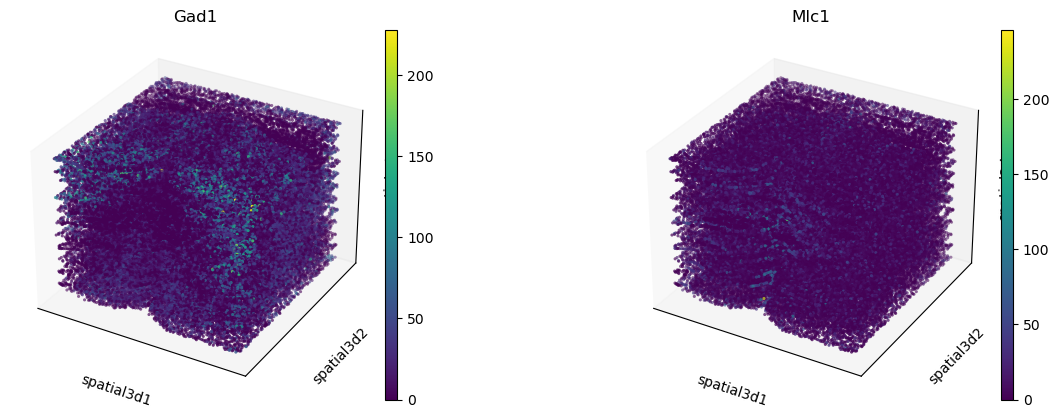

In [9]:
sc.pl.embedding(adata, basis="spatial3d", projection="3d", color=["Gad1", "Mlc1"])

If the same analysis should be performed on a single slice, then it is advisable to
copy the sample of interest in a new {class}`anndata.AnnData` and use it as
a standard 2D spatial data object.

100%|██████████| 1000/1000 [00:11<00:00, 87.51/s]


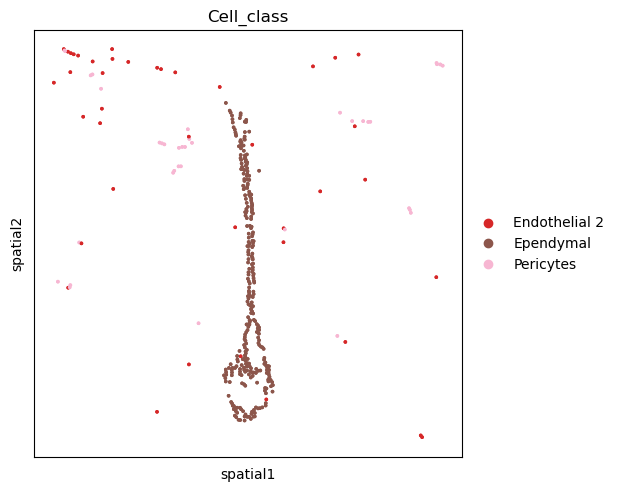

In [10]:
adata_slice = adata[adata.obs.Bregma == -9].copy()
sq.gr.spatial_neighbors(adata_slice, coord_type="generic")
sq.gr.nhood_enrichment(adata, cluster_key="Cell_class")
sq.pl.spatial_scatter(
    adata_slice,
    color="Cell_class",
    shape=None,
    groups=[
        "Ependymal",
        "Pericytes",
        "Endothelial 2",
    ],
    size=10,
)

Spatially variable genes with spatial autocorrelation statistics
----------------------------------------------------------------
With Squidpy we can investigate spatial variability of gene expression.
This is an example of a function that only supports 2D data.
{func}`squidpy.gr.spatial_autocorr` conveniently wraps two
spatial autocorrelation statistics: *Moran's I* and *Geary's C*.
They provide a score on the degree of spatial variability of gene expression.
The statistic as well as the p-value are computed for each gene, and FDR correction
is performed. For the purpose of this tutorial, let's compute the *Moran's I* score.
The results are stored in `adata.uns['moranI']` and we can visualize selected genes
with {func}`squidpy.pl.spatial_scatter`.

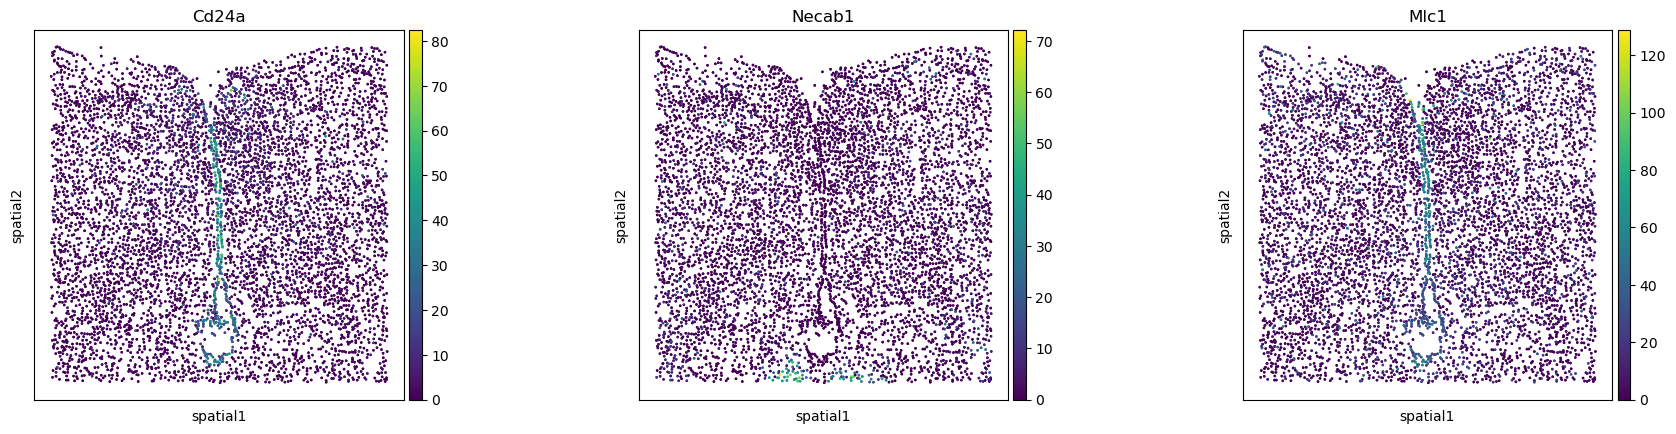

In [11]:
sq.gr.spatial_autocorr(adata_slice, mode="moran")
adata_slice.uns["moranI"].head()
sq.pl.spatial_scatter(
    adata_slice, shape=None, color=["Cd24a", "Necab1", "Mlc1"], size=3
)